In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [3]:
ImageSize=256
BatchSize=32
epoch=50

In [4]:
ds=tf.keras.preprocessing.image_dataset_from_directory("Training"
                                                       ,shuffle=True
                                                       ,image_size=(ImageSize,ImageSize)
                                                       ,batch_size=BatchSize)

Found 2152 files belonging to 3 classes.


In [5]:
classname=ds.class_names
classname

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

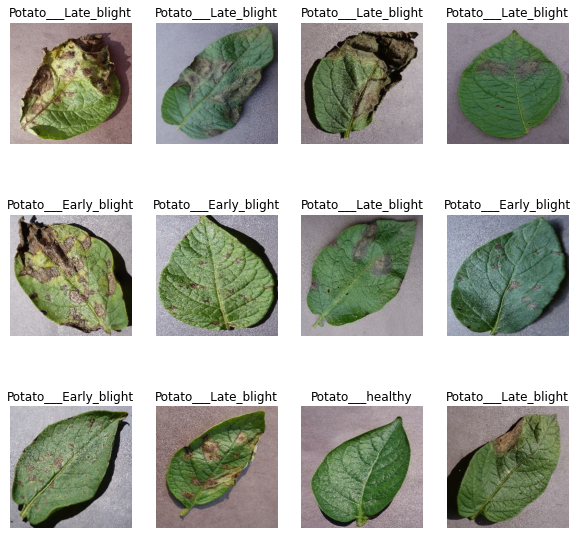

In [6]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in ds.take(1):
    for img in range(12):
        plt.subplot(3,4,img+1)
        plt.imshow(image_batch[img].numpy().astype('uint8'))
        plt.title(classname[label_batch[img]])
        plt.axis('off')

In [7]:
len(ds)

68

In [8]:
##ds_train=ds.take(54)

In [9]:
#ds_remaining=ds.skip(54)
##len(ds_remaining)

# ds_validation=ds_remaining.take(7)
##ds_test=ds_remaining.skip(7)
##len(ds_test)

In [10]:
def dataset_partition(ds , train_size=0.8 , validate_size=0.1 , test_size=0.1 , shuffle=True , shuffle_size=10000):
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    
    length = len(ds)
    trainsize=int(train_size*length)
    valsize=int(validate_size*length)
    ds_train = ds.take(trainsize)
    ds_validate = ds.skip(trainsize).take(valsize)
    ds_test = ds.skip(trainsize).skip(valsize)
    
    return ds_train,ds_validate,ds_test

In [11]:
ds_train,ds_validate,ds_test = dataset_partition(ds)

In [12]:
len(ds_test)

8

In [13]:
ds_train=ds_train.cache().shuffle(10000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
ds_validate=ds_validate.cache().shuffle(10000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
ds_test=ds_test.cache().shuffle(10000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [14]:
resize_rescale = tf.keras.Sequential([layers.experimental.preprocessing.Resizing(ImageSize,ImageSize),
                                     layers.experimental.preprocessing.Rescaling(1.0/256)])

In [28]:
data_augmentation = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                        layers.experimental.preprocessing.RandomRotation(0.2)])

In [31]:
CHANNELS = 3
input_shape = (BatchSize,ImageSize,ImageSize,CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [34]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])

In [35]:
history = model.fit(ds_train,epochs=epoch,batch_size=BatchSize,verbose=1,validation_data=ds_validate)

Epoch 1/50
54/54 [==============================] - 180s 3s/step - loss: 0.8997 - accuracy: 0.5064 - val_loss: 0.8770 - val_accuracy: 0.5052
Epoch 2/50
54/54 [==============================] - 162s 3s/step - loss: 0.6661 - accuracy: 0.6834 - val_loss: 0.4089 - val_accuracy: 0.8333
Epoch 3/50
54/54 [==============================] - 156s 3s/step - loss: 0.4145 - accuracy: 0.8322 - val_loss: 0.3971 - val_accuracy: 0.8438
Epoch 4/50
54/54 [==============================] - 155s 3s/step - loss: 0.2743 - accuracy: 0.8837 - val_loss: 0.1473 - val_accuracy: 0.9323
Epoch 5/50
54/54 [==============================] - 154s 3s/step - loss: 0.1797 - accuracy: 0.9265 - val_loss: 0.1361 - val_accuracy: 0.9323
Epoch 6/50
54/54 [==============================] - 147s 3s/step - loss: 0.1649 - accuracy: 0.9398 - val_loss: 0.1241 - val_accuracy: 0.9427
Epoch 7/50
54/54 [==============================] - 152s 3s/step - loss: 0.1334 - accuracy: 0.9421 - val_loss: 0.1650 - val_accuracy: 0.9375
Epoch 8/50
54

In [36]:
score = model.evaluate(ds_test)

8/8 [==============================] - 3s 329ms/step - loss: 0.0185 - accuracy: 0.9961


In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

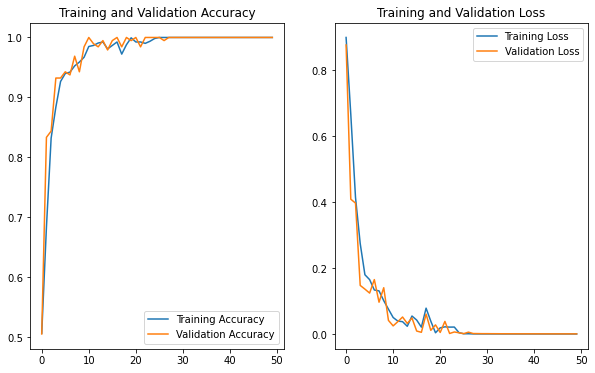

In [42]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(range(epoch), acc, label='Training Accuracy')
plt.plot(range(epoch), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epoch), loss, label='Training Loss')
plt.plot(range(epoch), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
predicted label: Potato___Early_blight


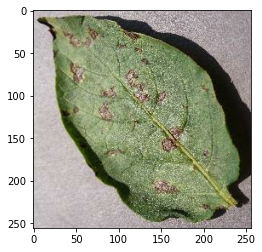

In [44]:
import numpy as np
for images_batch, labels_batch in ds_test.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classname[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",classname[np.argmax(batch_prediction[0])])

In [45]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    predicted_class = classname[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class , confidence

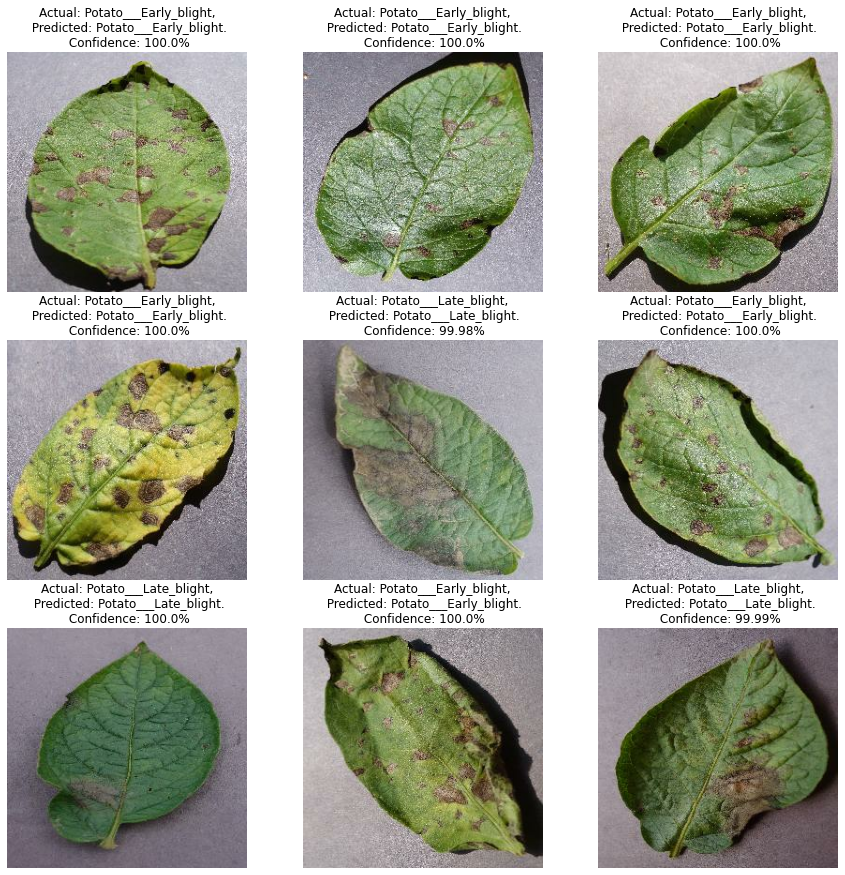

In [48]:
plt.figure(figsize=(15, 15))
for images, labels in ds_test.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class , confidence = predict(model,images[i].numpy())
        actual_class = classname[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [49]:
model_version = 1
model.save(f"../models/{model_version}")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../models/1\assets
